# Predict Future Sales

## Part 1: Import libraries and explain dataset

In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import csv

### File descriptions
- **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
- **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
- **sample_submission.csv** - a sample submission file in the correct format.
- **items.csv** - supplemental information about the items/products.
- **item_categories.csv**  - supplemental information about the items categories.
- **shops.csv**- supplemental information about the shops.


In [64]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')

### Training dataset
> Data description from the competition page

- **date** - date in format dd/mm/yyyy
- **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- **shop_id** - unique identifier of a shop
- **item_id** - unique identifier of a product
- **item_price** - current price of an item
- **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure

We use this data to train the model.

In [65]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Testing dataset

Given `shop_id` and `item_id`, we have to use our model to forecast the sales for these shops and products for November 2015.

**Submission file sample:**
```
    ID      item_cnt_month
     0                 0.5
     1                 0.5
     2                 0.5
    ...                   
```

In [66]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## Part 2: Data Exploration

In [67]:
#grouped = pd.DataFrame(train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index())
#grouped.head()

In [68]:
shop_group = train.groupby('shop_id')
shop_group_list = []
# Every item in the 'shop_group_list' is a shop group
for i in range(len(shop_group)):
    shop_group_list.append(shop_group.get_group(i))

shop_group_list[2].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
31951,14.01.2013,0,2,11330,149.0,1.0
31952,14.01.2013,0,2,11331,149.0,1.0
31953,14.01.2013,0,2,11332,149.0,1.0
31954,11.01.2013,0,2,11015,199.0,1.0
31955,07.01.2013,0,2,11030,149.0,1.0


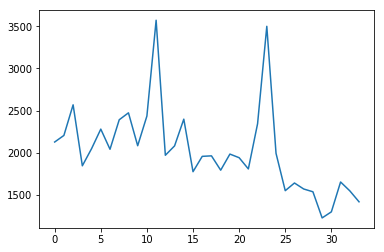

In [69]:
plt.plot(range(34), shop_group_list[35].groupby('date_block_num')['item_cnt_day'].sum())
plt.show()

## Part 3: Data Preprocessing

In [70]:
# Drop not used columns
train = train.drop(['date', 'item_price'], axis=1)
train.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0


In [71]:
# Group by ['date_block_num', 'shop_id', 'item_id']
train = train.groupby(['shop_id', 'item_id', 'date_block_num']).sum().reset_index()
train = train.rename(columns = {"item_cnt_day": "item_cnt_month"})
train.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


In [72]:
# This cell creates training data. Because it takes a lot of time during commit, so comment it.
'''cols = ['shop_id', 'item_id']
for i in range(29,34):
    cols.append('m'+str(i))
train_months = pd.DataFrame(columns = cols)
test_rows = []

for index, row in test.iterrows():
    temp = []
    sid = row['shop_id']
    iid = row['item_id']
    temp.append(sid)
    temp.append(iid)
    for m in range(29, 34):
        try:
            temp.append(train.loc[(train['shop_id'] == sid) & (train['item_id'] == iid) & (train['date_block_num'] == m)]['item_cnt_month'].values[0])
        except IndexError:
            temp.append(0)    
    test_rows.append(temp)
    if index % 100 == 0:
        print(index)

test_rows = pd.DataFrame(test_rows)
test_rows.columns = cols
train_months = train_months.append(test_rows)
train_months.head()'''

"cols = ['shop_id', 'item_id']\nfor i in range(29,34):\n    cols.append('m'+str(i))\ntrain_months = pd.DataFrame(columns = cols)\ntest_rows = []\n\nfor index, row in test.iterrows():\n    temp = []\n    sid = row['shop_id']\n    iid = row['item_id']\n    temp.append(sid)\n    temp.append(iid)\n    for m in range(29, 34):\n        try:\n            temp.append(train.loc[(train['shop_id'] == sid) & (train['item_id'] == iid) & (train['date_block_num'] == m)]['item_cnt_month'].values[0])\n        except IndexError:\n            temp.append(0)    \n    test_rows.append(temp)\n    if index % 100 == 0:\n        print(index)\n\ntest_rows = pd.DataFrame(test_rows)\ntest_rows.columns = cols\ntrain_months = train_months.append(test_rows)\ntrain_months.head()"

In [73]:
# read the output of above cell
train_new = pd.read_csv('../input/predict-sales-training-data/train_months.csv')

In [74]:
train_new.head()

,shop_id,item_id,m29,m30,m31,m32,m33
0,5,5037,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0
2,5,5233,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0


In [75]:
# Get the categories of testing items
test_cate = []
for index, row in train_new.iterrows():
    test_cate.append(items.loc[(items['item_id'] == row[1])]['item_category_id'].values[0])

In [76]:
cate = pd.DataFrame(test_cate, columns=['item_category'])
train_new = pd.concat([train_new, cate], axis=1)
train_new.head()

,shop_id,item_id,m29,m30,m31,m32,m33,item_category
0,5,5037,1.0,1.0,3.0,1.0,0.0,19
1,5,5320,0.0,0.0,0.0,0.0,0.0,55
2,5,5233,2.0,0.0,1.0,3.0,1.0,19
3,5,5232,0.0,0.0,1.0,0.0,0.0,23
4,5,5268,0.0,0.0,0.0,0.0,0.0,20


In [77]:
x_train = np.expand_dims(np.concatenate((train_new.values[:, :1], train_new.values[:, 2:-2], train_new.values[:, -1:]), axis=1), axis=2)
y_train = train_new.values[:, -2:-1]
x_test = np.expand_dims(np.concatenate((train_new.values[:, :1], train_new.values[:, 3:]), axis=1), axis=2)
print(x_train.shape, y_train.shape, x_test.shape)

(214200, 6, 1) (214200, 1) (214200, 6, 1)


In [ ]:
train_new.to_csv('train_new_3.csv',index=False)

print('Saved file: ' + 'train_new_3.csv')

## Part 4: Training the model
**主要策略：利用該商店該商品前四個月的銷量、以及該商品的種類，來預測下個月的銷量**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(6, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()

In [ ]:
history = model.fit(x_train, y_train, batch_size=2048, epochs=200)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
def write_submission(y_pred):
    with open('submission_file_4.csv', 'w') as output:
        writer = csv.writer(output)
        writer.writerow(['ID', 'item_cnt_month'])
        for i, y in enumerate(y_pred):
            writer.writerow([i, y])
write_submission(y_pred)

## Other attempts

In [ ]:
'''month_list = [i for i in range(34)]
cnt_month = []
for i in range(34):
    cnt_month.append(0)
def create_month_list(item_id, shop_id):
    shop = []
    for i in range(34):
        shop.append(shop_id)
    item = []
    for i in range(34):
        item.append(item_id)
    months = pd.DataFrame({'shop_id': shop, 'item_id': item, 'date_block_num': month_list, 'item_cnt_month': cnt_month})
    return months'''

In [ ]:
'''try:
    train.loc[(train['shop_id'] == 0) & (train['item_id'] == 32) & (train['date_block_num'] == 2)]['item_cnt_month'].values[0]
except IndexError:
    print('error')'''

In [ ]:
'''df = pd.DataFrame(columns = ['shop_id', 'item_id', 'date_block_num', 'item_cnt_month'])
pre_pair = ()
for index, row in train.iterrows():
    # If the (item_id, shop_id) is the same as the previous row
    if pre_pair == (row['item_id'], row['shop_id']) and row['item_cnt_month'] != 0:
        temp_index = df.loc[(df['shop_id'] == row['shop_id']) & (df['item_id'] == row['item_id']) & (df['date_block_num'] == row['date_block_num'])].index[0]
        df.loc[temp_index, 'item_cnt_month'] = row['item_cnt_month']
        continue
    pre_pair = (row['item_id'], row['shop_id'])
    df = df.append(create_month_list(row['item_id'], row['shop_id'])).reset_index(drop = True)
    if row['item_cnt_month'] != 0:
        temp_index = df.loc[(df['shop_id'] == row['shop_id']) & (df['item_id'] == row['item_id']) & (df['date_block_num'] == row['date_block_num'])].index[0]
        df.loc[temp_index, 'item_cnt_month'] = row['item_cnt_month']
df
#print(train.loc[(train['shop_id'] == 0) & (train['item_id'] == 30)]['item_cnt_month'].values[0])
#print(train.loc[(train['shop_id'] == 0) & (train['item_id'] == 97)].index[0])'''

In [ ]:
'''#train.loc[(train['shop_id'] == 0) & (train['item_id'] == 30)]['item_cnt_month'] = 20
print(train.loc[(train['shop_id'] == 0) & (train['item_id'] == 97)].index[0])'''